In [1]:
from ceo import constants, StopWatch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/CEO/python/ceo/zemax


# WFPT model demo (v2)
This demo shows how to use the Wide Field Phasing Testbed (WFPT) model developed in CEO, using a single on-axis DFS.

Developed by: F. Quiros-Pacheco (GMTO)

Last update: 25/02/2022

## Initialize WFPT model
The WFPT package is located in **~/CEO/python/ceo/wfpt/** . There are so far three WFPT classes:
1. **wfpt_testbed**. The main WFPT testbed class that enables ray tracing through the WFPT Zemax model imported in CEO.
2. **wfpt_source**. The class that emulates the illumination source. It contains a "rays bundle" object to raytrace through the WFPT model, and a "CEO Source" object to enable WF propagation from the exit pupil of the WFPT testbed to the WFS. Currently only on-axis propagation possible.
3. **wfpt_dfs**. A wrapper class for the "CEO DispersedFringeSensor" class that implements the DFS model.

In [2]:
from ceo import wfpt_testbed, wfpt_source, wfpt_dfs

In [3]:
#----------------- WFPT model -----------------------------------
M2_baffle_diam=3.6  # size of M2 baffle
project_truss_onaxis=True # simulate truss shadows over central segment

wfpt = wfpt_testbed(M2_baffle_diam=M2_baffle_diam, project_truss_onaxis=project_truss_onaxis,
                   path_to_sensor='DFS')

In [4]:
#----------------- DFS Source model ------------------------------
dfs_band = 'J'
dfs_mag = 12
J_bkgd_mag = 16.2 # J-band sky bkgd (mag/arcsec^2); Tech Note GMT-02274, rev 2.4
J_e0 = 1.88e12    # ph/s in J band over the GMT pupil
dfs_D = 27.41     # [m]

dfs_nPx = 481
src = wfpt_source(dfs_band, dfs_nPx, dfs_D, mag=dfs_mag)

In [5]:
#----------------- DFS model ------------------------------------
dfs = wfpt_dfs(src)

## Propagate a flat wavefront and do calibrations
Activate the keyword **keep_rays_for_plot** if you want to show a ray diagram. Otherwise, set it to *False* to speed up the ray tracing.

In [6]:
keep_rays_for_plot = True

In [7]:
%%time
src.reset()
wfpt.reset()
wfpt.propagate(src, keep_rays_for_plot=keep_rays_for_plot)
opd0 = src._gs.phase.host()

CPU times: user 584 ms, sys: 344 ms, total: 928 ms
Wall time: 926 ms


### Show the WF at the exit pupil

on-axis WFE: 7.2 nm RMS


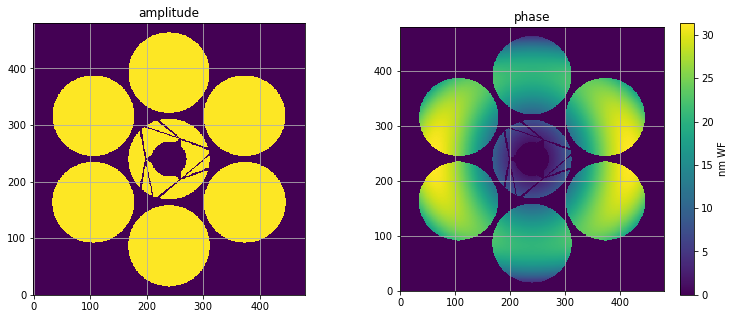

In [8]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
ax1.imshow(src._gs.amplitude.host(), origin='lower',interpolation='None')
ax1.set_aspect('equal')
ax1.grid()
im2 = ax2.imshow(opd0*1e9, origin='lower', interpolation='None')
h2 = plt.colorbar(im2, ax=ax2, label='nm WF')
ax1.set_title('amplitude')
ax2.set_aspect('equal')
ax2.grid()
ax2.set_title('phase')

print("on-axis WFE: %0.1f nm RMS"%(src._gs.phaseRms()*1e9))

### Show the rays diagram

In [9]:
if keep_rays_for_plot:
    xyz,klm,sid = wfpt.rays_data
    vig = src.rays.vignetting.host().ravel()>0

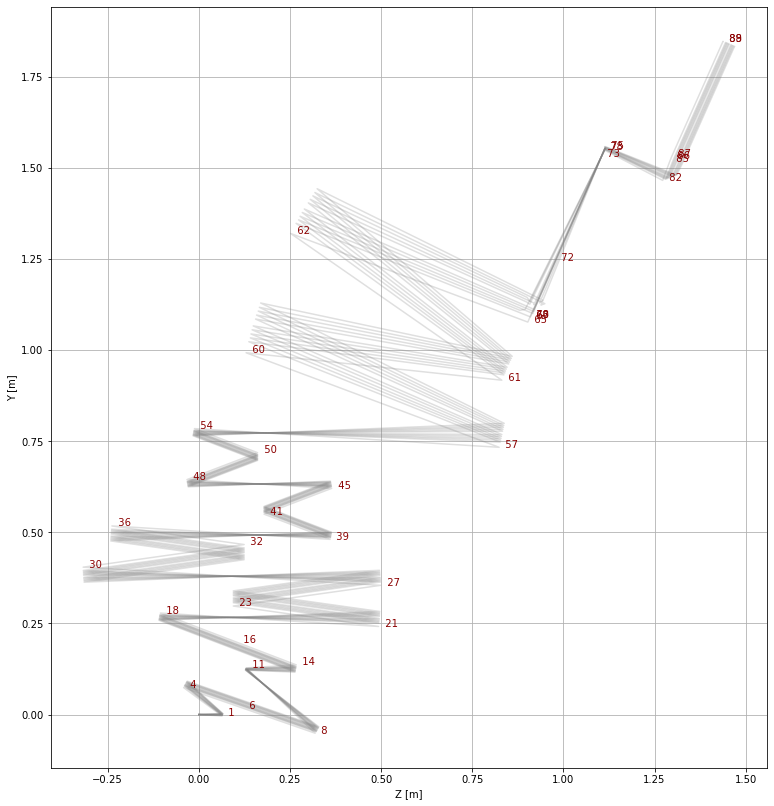

In [10]:
if keep_rays_for_plot:
    fig,ax = plt.subplots(figsize=(16,14))
    #plt.style.use('dark_background')
    for k in range(1,vig.sum(),10000):
        ray = np.vstack([w[vig,:][k] for w in xyz[:len(sid)+1]])
        ax.plot(ray[:,2],ray[:,1],'gray',alpha=0.25)    
    chief_ray = np.vstack([w[vig,:][0] for w in xyz[:len(sid)+1]])
    htz = [ax.text(chief_ray[k+1,2],chief_ray[k+1,1],f"  {sid[k]}",fontdict={'color':'darkred'}) for k in range(len(sid))]
    #chief_ray = np.vstack([w[vig,:][-1] for w in xyz[:len(sid)+1]])
    #htc = [ax.text(chief_ray[k+1,2],chief_ray[k+1,1],f"  {k+1}") for k in range(len(sid))]
    ax.grid()
    ax.set_aspect('equal')
    ax.set_xlabel('Z [m]')
    ax.set_ylabel('Y [m]');

### Calibrate DFS

In [11]:
dfs.calibrate(src)

In [13]:
wfpt.reset()
src.reset()
wfpt.propagate(src)
dfs.reset()
dfs.propagate(src)
dfs.fft()
fringes = dfs.get_data_cube(data_type='camera')

(<matplotlib.image.AxesImage at 0x7f04cbd13df0>, (38, 38, 12))

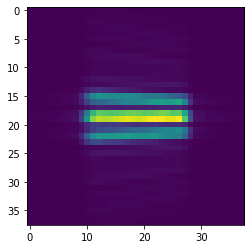

In [14]:
plt.imshow(fringes[:,:,0]), fringes.shape

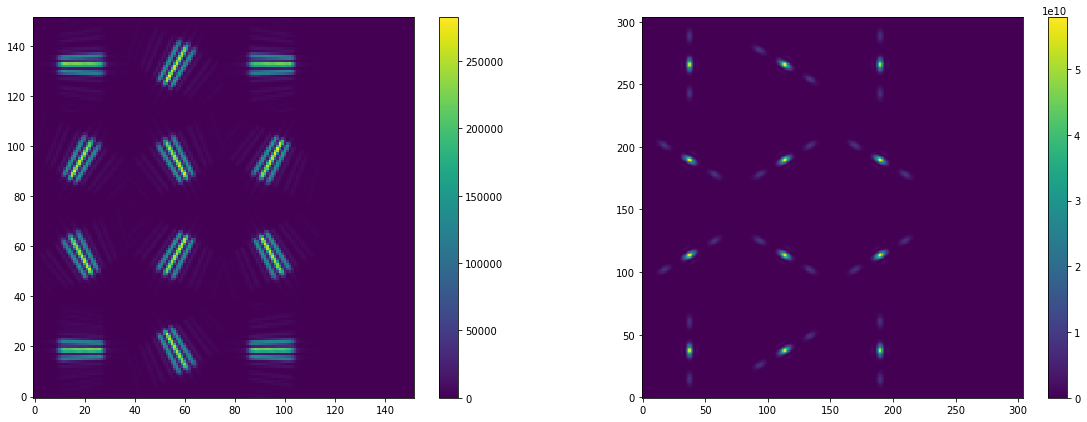

In [15]:
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((20,7))
h1 = ax1.imshow(dfs.camera.frame.host(),interpolation='None',origin='lower')
fig.colorbar(h1,ax=ax1)
h2 = ax2.imshow(dfs.fftlet.host(),interpolation='None',origin='lower')
fig.colorbar(h2,ax=ax2);

## Apply commands to Active Mirrors and propagate wavefront
A state vector is defined containing the following degrees of freedom:
1. **M1_PTT**: 
    1. *segment piston*    (7)
    2. *segment tip-tilt*  (7x2)
2. **M2_PTT:** idem
3. **M1_DM:** 
    1. *actuators*      (292)
4. **M2_DM:** idem

In [16]:
print(wfpt.state)

{'M1_PTT': {'segment piston': array([0., 0., 0., 0., 0., 0., 0.]), 'segment tip-tilt': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])}, 'M2_PTT': {'segment piston': array([0., 0., 0., 0., 0., 0., 0.]), 'segment tip-tilt': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])}, 'M1_DM': {'actuators': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 

To apply a command you should:
1. Extract a copy of the state vector (can be done only once);
2. Modify the copy of the state vector as desired;
3. Update the WFPT model with the desired state vector.

In [17]:
wfpt.reset()

# Extract copy of state vector
state = wfpt.state

# Modify the state vector as desired
state['M2_PTT']['segment piston'][0:6:2] = 1e-6

# Update the WFPT model with the desired state vector
wfpt.update(state)

Propagate WF

In [18]:
%%time
src.reset()
wfpt.propagate(src)
opd = src._gs.phase.host()

CPU times: user 312 ms, sys: 148 ms, total: 460 ms
Wall time: 458 ms


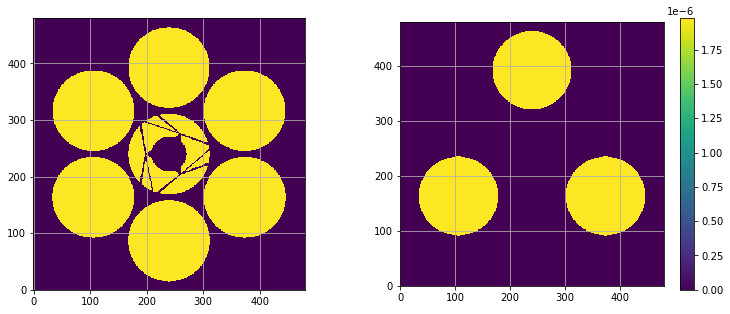

In [19]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
ax1.imshow(src._gs.amplitude.host(), origin='lower',interpolation='None')
ax1.set_aspect('equal')
ax1.grid()
im2 = ax2.imshow(opd-opd0, origin='lower', interpolation='None')
h2 = plt.colorbar(im2, ax=ax2)
ax2.set_aspect('equal')
ax2.grid()

### DFS measurements

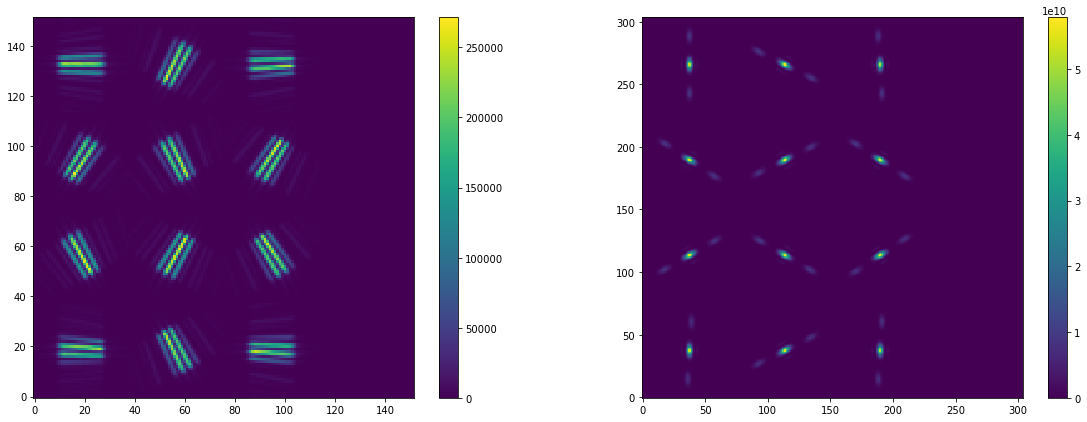

In [20]:
dfs.reset()
dfs.propagate(src)
dfs.fft()
dfs.process()

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((20,7))
h1 = ax1.imshow(dfs.camera.frame.host(),interpolation='None',origin='lower')
fig.colorbar(h1,ax=ax1)
h2 = ax2.imshow(dfs.fftlet.host(),interpolation='None',origin='lower')
fig.colorbar(h2,ax=ax2)

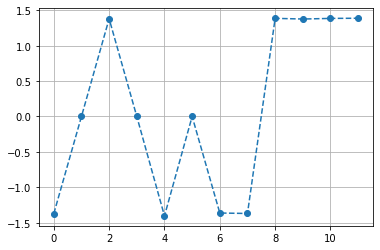

In [22]:
plt.plot(dfs.get_measurement(), 'o--')
plt.grid()

# Interaction Matrix Calibration

## M1 PTT segment piston - DFS

In [23]:
%%time
D_spp_dfs = wfpt.calibrate(dfs, src, mirror='M1', mode='segment piston', stroke=50e-9)

___ M1 ___ (segment piston)
Segment #:1 2 3 4 5 6 7 
------------
CPU times: user 4.61 s, sys: 2.1 s, total: 6.71 s
Wall time: 6.7 s


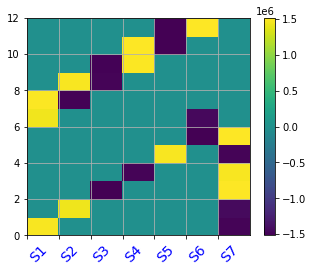

In [30]:
    fig2, ax2 = plt.subplots()
    fig2.set_size_inches(5,4)

    imm = ax2.pcolor(D_spp_dfs)
    ax2.grid()
    ax2.set_ylim([0,12])
    ax2.set_xticks(range(7))
    ax2.set_xticklabels(['S1','S2','S3','S4','S5','S6','S7'], ha='left', fontsize=14, 
                        rotation=45, color='b')
    fig2.colorbar(imm);

## Reconstruction Matrix
Inverse of M1_DM-SH matrix

M1 PTT SPP - DFS IM:
(12, 7)
conditioning number:
651468.7331813719


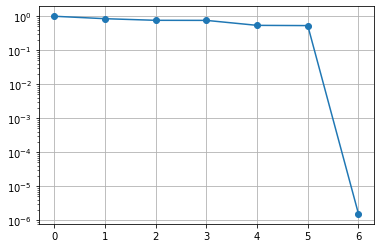

In [31]:
print('M1 PTT SPP - DFS IM:')
print(D_spp_dfs.shape)
print("conditioning number:")
print(np.linalg.cond(D_spp_dfs))

UU1, ss1, VVT1 = np.linalg.svd(D_spp_dfs, full_matrices=False)
plt.semilogy(ss1/np.max(ss1), 'o-')
plt.grid()

In [33]:
R_spp_dfs = np.linalg.pinv(D_spp_dfs, rcond=1e-3)

### Test reconstructor

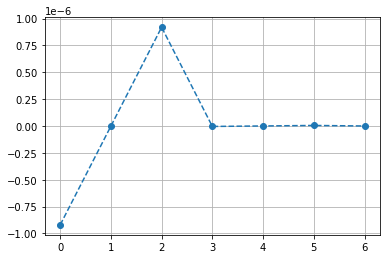

In [34]:
wfpt.reset()
state = wfpt.state
state['M1_PTT']['segment piston'][0] = -1e-6
state['M1_PTT']['segment piston'][2] = 1e-6

wfpt.update(state)

src.reset()
wfpt.propagate(src)
WFin = src._gs.phase.host()

dfs.reset()
dfs.propagate(src)
dfs.fft()
dfs.process()
dfs_meas = dfs.get_measurement()

spp_comm = R_spp_dfs @ dfs_meas

#plt.imshow(WFin-opd0, origin='lower', interpolation='None')
#plt.colorbar()
plt.plot(spp_comm, 'o--')
plt.grid()

# Perform a closed-loop test
Introduce an initial scramble of segment piston, and close the loop with the PTT array.

## Introduce a scramble

In [35]:
from numpy.random import default_rng
rng = default_rng(seed=1454)

WFE: 1489.5 nm RMS


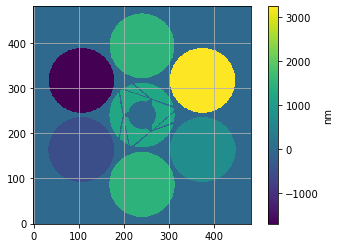

In [36]:
# Scramble:
wfpt.reset()
state0 = wfpt.state
state0['M1_PTT']['segment piston'][:] = rng.standard_normal(size=(7)) * 1e-6
wfpt.update(state0)

# Visualize the scramble
src.reset()
wfpt.propagate(src)
opd = src._gs.phase.host()
print("WFE: %0.1f nm RMS"%(src._gs.phaseRms()*1e9))
fig, ax2 = plt.subplots()
im2 = ax2.imshow((opd-opd0)*1e9, origin='lower', interpolation='None')
h2 = plt.colorbar(im2, ax=ax2, label='nm')
ax2.set_aspect('equal')
ax2.grid()

## Close the loop

In [37]:
import sys

In [38]:
totSimulIter = 30
gain = 0.2
tid = StopWatch()

M1_DM_comm_buffer = np.zeros(7)
wfe_iter = np.zeros(totSimulIter)

In [40]:
# Get 
wfpt.reset()
state = wfpt.state

# Load initial scramble
wfpt.update(state0)

for jj in range(totSimulIter):
    tid.tic()
    src.reset()
    wfpt.propagate(src)
    wfe_iter[jj] = src._gs.wavefront.rms()
    
    #--- WFS measurements and command
    dfs.reset()
    dfs.propagate(src)
    dfs.fft()
    dfs.process()
    measvec = dfs.get_measurement()
    M1_DM_delta_comm = R_spp_dfs @ measvec
    M1_DM_comm_buffer += gain * M1_DM_delta_comm
    
    #--- Update state vector
    state['M1_PTT']['segment piston'] = -M1_DM_comm_buffer
    wfpt.update(state0+state)

    tid.toc()
    sys.stdout.write("\r iter: %d/%d, ET: %.2f, WFE [nm WF RMS] on-axis: %0.1f"%(jj, totSimulIter, tid.elapsedTime, wfe_iter[jj]*1e9))
    sys.stdout.flush()   


 iter: 29/30, ET: 482.68, WFE [nm WF RMS] on-axis: 7.394

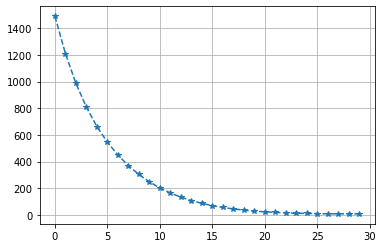

In [41]:
plt.plot(wfe_iter*1e9, '*--')
plt.grid()

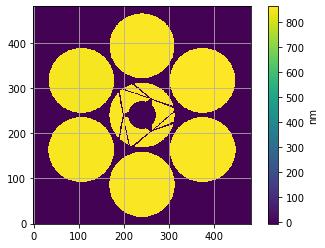

In [42]:
opd = src._gs.phase.host()

fig, ax2 = plt.subplots()
im2 = ax2.imshow((opd-opd0)*1e9, origin='lower', interpolation='None')
h2 = plt.colorbar(im2, ax=ax2, label='nm')
ax2.set_aspect('equal')
ax2.grid()

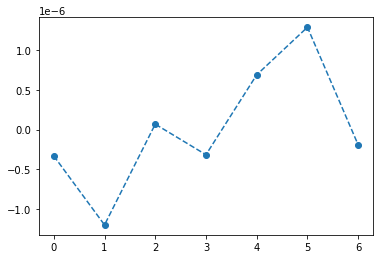

In [43]:
plt.plot(M1_DM_comm_buffer, 'o--')